In [ ]:
from gene import Gene

import os
import shutil
import json
from pathlib import Path
from tqdm import trange
import numpy as np
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from colabfold.batch import get_queries, run
from colabfold.download import default_data_dir
from colabfold.utils import setup_logging
from matplotlib import pyplot as plt

: 

In [ ]:

def clear_dir(filepath):
    for root, dirs, files in os.walk(filepath):
        for f in files:
            os.unlink(os.path.join(root, f))
        for d in dirs:
            shutil.rmtree(os.path.join(root, d))

def save_proteins(genes, folder):
    os.mkdir(folder)
    for i, gene in enumerate(genes):
        protein = gene.get_protein()
        record = SeqRecord(protein, id=str(i), description=str(gene))
        filename = f'{folder}/gene{i}.fasta'
        gene.fasta = filename
        SeqIO.write(record, f'{folder}/gene{i}.fasta', 'fasta')
    
def fold(input_dir, result_dir, kwargs):
    setup_logging(Path(result_dir).joinpath("log.txt"))
    kwargs['queries'], kwargs['is_complex'] = get_queries(input_dir)
    kwargs['result_dir'] = result_dir
    results = run(**kwargs)
    return results

def calculate_fitnesses(genes, results):
    for gene, metric in zip(genes, results['metric']):
        mean_plddt, ptm = metric[0]['mean_plddt'], metric[0]['ptm']
        fitness = (mean_plddt / 100) * 0.5 + ptm * 0.5 + len(gene.get_protein()) * 0.01
        gene.fitness = fitness

def log_evolution(generations, logfile):
    with open(logfile, 'w') as f:
        data = [[gene.__dict__ for gene in gen] for gen in generations]
        json.dump(data, f)

def read_evolution(logfile):
    with open(logfile, 'r') as f:
        data = json.load(f)
        generations = [[Gene(**d) for d in gen] for gen in data]
    return generations

def plot_fitnesses(generations):
    fig = plt.figure()
    x = np.arange(len(generations))
    y = [np.mean([gene.fitness for gene in gen]) for gen in generations]
    yerr = [np.std([gene.fitness for gene in gen]) for gen in generations]
    plt.errorbar(x, y, yerr=yerr)
    plt.show()

: 

In [2]:
n_genes = 3
n_bases = 50
n_generations = 3
proteins_path = 'proteins'
folds_path = 'folds'
logfile = 'log.txt'

colabfold_params = {
    'msa_mode': "single_sequence", #@param ["MMseqs2 (UniRef+Environmental)", "MMseqs2 (UniRef only)","single_sequence","custom"]
    'num_models': 1, #@param [1,2,3,4,5] {type:"raw"}
    'num_recycles': 3, #@param [1,3,6,12,24,48] {type:"raw"}
    'stop_at_score': 100, #@param {type:"string"}
    'num_relax': 0, #@param [0, 1, 5] {type:"raw"}
    'use_amber': False,
    'relax_max_iterations': 200, #@param [0,200,2000] {type:"raw"}
    'use_templates': False, #@param {type:"boolean"}
    'keep_existing_results': True, #@param {type:"boolean"}
    'zip_results': False, #@param {type:"boolean"}
    'model_type': "auto",
    'model_order': [1, 2, 3, 4, 5],
    'data_dir': default_data_dir,
    'keep_existing_results': True,
    'rank_by': "auto",
    'pair_mode': "unpaired+paired",
    'user_agent': "colabfold/google-colab-batch",
}

NameError: name 'default_data_dir' is not defined

In [6]:
clear_dir(proteins_path)
clear_dir(folds_path)

In [7]:
# first generation
generation = [Gene.generate(n_bases) for _ in range(n_genes)]
# filter empty proteins (begins with stop codon)
generation = [gene for gene in generation if len(gene.get_protein()) > 0]
save_proteins(generation, f'{proteins_path}/gen{0}')
results = fold(f'{proteins_path}/gen{0}', f'{folds_path}/gen{0}', colabfold_params)
calculate_fitnesses(generation, results)
generations = [generation]

# subsequent generations
for i in trange(1, n_generations+1):
    
    mutations = [gene.random_mutation() for gene in generation]
    # remove empty proteins
    mutations = [gene for gene in mutations if len(gene.get_protein()) > 0]

    # fold mutated proteins and calculate fitnesses as a batch
    save_proteins(mutations, f'{proteins_path}/gen{i}')
    results = fold(f'{proteins_path}/gen{i}', f'{folds_path}/gen{i}', colabfold_params)
    calculate_fitnesses(mutations, results)
    generation += mutations

    # stochastic selection
    fitnesses = [gene.fitness for gene in generation]
    generation = np.random.choice(generation, size=n_genes, replace=False, p=np.divide(fitnesses, sum(fitnesses))).tolist()
    generations.append(generation)

log_evolution(generations, logfile)

/home/ben/code/localcolabfold/colabfold-conda/lib/python3.10/site-packages/Bio/Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


2024-12-30 11:42:28,766 Running on GPU
2024-12-30 11:42:29,048 Found 2 citations for tools or databases
2024-12-30 11:42:29,049 Query 1/2: gene0 (length 16)


I0000 00:00:1735576956.193201    6759 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


2024-12-30 11:42:45,153 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=71.7 pTM=0.0291
2024-12-30 11:42:45,251 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=74.7 pTM=0.0305 tol=0.113
2024-12-30 11:42:45,346 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=75.2 pTM=0.0308 tol=0.0355
2024-12-30 11:42:45,439 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=75.6 pTM=0.031 tol=0.0432
2024-12-30 11:42:45,439 alphafold2_ptm_model_1_seed_000 took 9.0s (3 recycles)
2024-12-30 11:42:45,442 reranking models by 'plddt' metric
2024-12-30 11:42:45,442 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=75.6 pTM=0.031
2024-12-30 11:42:45,746 Query 2/2: gene1 (length 16)
2024-12-30 11:42:46,940 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=66.2 pTM=0.0266
2024-12-30 11:42:47,040 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=65.7 pTM=0.0268 tol=1.29
2024-12-30 11:42:47,139 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=67.4 pTM=0.0269 tol=0.468
2024-12-30 11:42:47,239 alphafold2_ptm_model_1_seed_000 r

/home/ben/code/localcolabfold/colabfold-conda/lib/python3.10/site-packages/Bio/Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(


2024-12-30 11:42:47,704 Done


  0%|          | 0/3 [00:00<?, ?it/s]

2024-12-30 11:42:47,707 Running on GPU
2024-12-30 11:42:47,711 Found 2 citations for tools or databases
2024-12-30 11:42:47,713 Query 1/2: gene1 (length 16)


  0%|          | 0/3 [00:03<?, ?it/s]

2024-12-30 11:42:51,072 Padding length to 18


  0%|          | 0/3 [00:13<?, ?it/s]

2024-12-30 11:43:00,980 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=73.2 pTM=0.0322
2024-12-30 11:43:01,101 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=78.9 pTM=0.0354 tol=0.447


  0%|          | 0/3 [00:13<?, ?it/s]

2024-12-30 11:43:01,222 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=79.5 pTM=0.0359 tol=0.0635
2024-12-30 11:43:01,341 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=79.6 pTM=0.0363 tol=0.0268
2024-12-30 11:43:01,343 alphafold2_ptm_model_1_seed_000 took 10.3s (3 recycles)
2024-12-30 11:43:01,348 reranking models by 'plddt' metric
2024-12-30 11:43:01,351 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=79.6 pTM=0.0363


  0%|          | 0/3 [00:13<?, ?it/s]

2024-12-30 11:43:01,659 Query 2/2: gene0 (length 18)


  0%|          | 0/3 [00:15<?, ?it/s]

2024-12-30 11:43:02,898 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=75.2 pTM=0.0282
2024-12-30 11:43:03,016 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=81.8 pTM=0.0318 tol=0.109


  0%|          | 0/3 [00:15<?, ?it/s]

2024-12-30 11:43:03,134 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=82.9 pTM=0.0327 tol=0.0285
2024-12-30 11:43:03,254 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=83.1 pTM=0.033 tol=0.0221
2024-12-30 11:43:03,257 alphafold2_ptm_model_1_seed_000 took 0.5s (3 recycles)
2024-12-30 11:43:03,262 reranking models by 'plddt' metric
2024-12-30 11:43:03,264 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=83.1 pTM=0.033


  0%|          | 0/3 [00:15<?, ?it/s]/home/ben/code/localcolabfold/colabfold-conda/lib/python3.10/site-packages/Bio/Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
 33%|███▎      | 1/3 [00:15<00:31, 15.86s/it]

2024-12-30 11:43:03,558 Done
2024-12-30 11:43:03,571 Running on GPU
2024-12-30 11:43:03,575 Found 2 citations for tools or databases
2024-12-30 11:43:03,578 Query 1/3: gene1 (length 17)


 33%|███▎      | 1/3 [00:19<00:31, 15.86s/it]

2024-12-30 11:43:06,882 Padding length to 27


 33%|███▎      | 1/3 [00:29<00:31, 15.86s/it]

2024-12-30 11:43:16,624 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=68.4 pTM=0.0286
2024-12-30 11:43:16,781 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=66.9 pTM=0.028 tol=0.56


 33%|███▎      | 1/3 [00:29<00:31, 15.86s/it]

2024-12-30 11:43:16,936 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=71.8 pTM=0.0307 tol=0.606
2024-12-30 11:43:17,091 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=74.3 pTM=0.0325 tol=0.781
2024-12-30 11:43:17,094 alphafold2_ptm_model_1_seed_000 took 10.2s (3 recycles)
2024-12-30 11:43:17,103 reranking models by 'plddt' metric
2024-12-30 11:43:17,106 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=74.3 pTM=0.0325


 33%|███▎      | 1/3 [00:29<00:31, 15.86s/it]

2024-12-30 11:43:17,411 Query 2/3: gene2 (length 17)


 33%|███▎      | 1/3 [00:31<00:31, 15.86s/it]

2024-12-30 11:43:18,746 Padding length to 27
2024-12-30 11:43:18,907 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=74.1 pTM=0.0296


 33%|███▎      | 1/3 [00:31<00:31, 15.86s/it]

2024-12-30 11:43:19,069 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=77.2 pTM=0.0316 tol=1.09
2024-12-30 11:43:19,225 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=74.8 pTM=0.0301 tol=1.35


 33%|███▎      | 1/3 [00:31<00:31, 15.86s/it]

2024-12-30 11:43:19,379 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=72.3 pTM=0.0292 tol=0.758
2024-12-30 11:43:19,382 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-30 11:43:19,387 reranking models by 'plddt' metric
2024-12-30 11:43:19,389 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=72.3 pTM=0.0292


 33%|███▎      | 1/3 [00:31<00:31, 15.86s/it]

2024-12-30 11:43:19,696 Query 3/3: gene0 (length 27)


 33%|███▎      | 1/3 [00:33<00:31, 15.86s/it]

2024-12-30 11:43:20,954 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=61.7 pTM=0.181
2024-12-30 11:43:21,111 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=65.6 pTM=0.189 tol=1.98


 33%|███▎      | 1/3 [00:33<00:31, 15.86s/it]

2024-12-30 11:43:21,263 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=66.6 pTM=0.196 tol=0.421
2024-12-30 11:43:21,416 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=67.1 pTM=0.198 tol=0.425
2024-12-30 11:43:21,419 alphafold2_ptm_model_1_seed_000 took 0.6s (3 recycles)
2024-12-30 11:43:21,425 reranking models by 'plddt' metric
2024-12-30 11:43:21,427 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=67.1 pTM=0.198


 33%|███▎      | 1/3 [00:34<00:31, 15.86s/it]/home/ben/code/localcolabfold/colabfold-conda/lib/python3.10/site-packages/Bio/Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
 67%|██████▋   | 2/3 [00:34<00:17, 17.21s/it]

2024-12-30 11:43:21,725 Done
2024-12-30 11:43:21,730 Running on GPU
2024-12-30 11:43:21,735 Found 2 citations for tools or databases
2024-12-30 11:43:21,738 Query 1/3: gene1 (length 5)


 67%|██████▋   | 2/3 [00:37<00:17, 17.21s/it]

2024-12-30 11:43:25,207 Padding length to 15


 67%|██████▋   | 2/3 [00:47<00:17, 17.21s/it]

2024-12-30 11:43:35,196 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=73.4 pTM=0.0746
2024-12-30 11:43:35,320 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=58.4 pTM=0.0709 tol=1.4


 67%|██████▋   | 2/3 [00:47<00:17, 17.21s/it]

2024-12-30 11:43:35,427 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=47.8 pTM=0.0715 tol=2.24
2024-12-30 11:43:35,536 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=33 pTM=0.0649 tol=1.25
2024-12-30 11:43:35,539 alphafold2_ptm_model_1_seed_000 took 10.3s (3 recycles)
2024-12-30 11:43:35,544 reranking models by 'plddt' metric
2024-12-30 11:43:35,547 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=33 pTM=0.0649


 67%|██████▋   | 2/3 [00:48<00:17, 17.21s/it]

2024-12-30 11:43:35,867 Query 2/3: gene2 (length 13)


 67%|██████▋   | 2/3 [00:49<00:17, 17.21s/it]

2024-12-30 11:43:37,204 Padding length to 15
2024-12-30 11:43:37,314 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=69.9 pTM=0.0348


 67%|██████▋   | 2/3 [00:49<00:17, 17.21s/it]

2024-12-30 11:43:37,417 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=77.8 pTM=0.0417 tol=0.585
2024-12-30 11:43:37,524 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=79.6 pTM=0.0422 tol=0.0914


 67%|██████▋   | 2/3 [00:49<00:17, 17.21s/it]

2024-12-30 11:43:37,630 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=79.8 pTM=0.0428 tol=0.206
2024-12-30 11:43:37,634 alphafold2_ptm_model_1_seed_000 took 0.4s (3 recycles)
2024-12-30 11:43:37,643 reranking models by 'plddt' metric
2024-12-30 11:43:37,646 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=79.8 pTM=0.0428


 67%|██████▋   | 2/3 [00:50<00:17, 17.21s/it]

2024-12-30 11:43:37,960 Query 3/3: gene0 (length 18)


 67%|██████▋   | 2/3 [00:59<00:17, 17.21s/it]

2024-12-30 11:43:47,304 alphafold2_ptm_model_1_seed_000 recycle=0 pLDDT=70.2 pTM=0.0284
2024-12-30 11:43:47,429 alphafold2_ptm_model_1_seed_000 recycle=1 pLDDT=73.6 pTM=0.0307 tol=0.168


 67%|██████▋   | 2/3 [00:59<00:17, 17.21s/it]

2024-12-30 11:43:47,553 alphafold2_ptm_model_1_seed_000 recycle=2 pLDDT=74.2 pTM=0.0311 tol=0.0664
2024-12-30 11:43:47,679 alphafold2_ptm_model_1_seed_000 recycle=3 pLDDT=74.3 pTM=0.0311 tol=0.0814
2024-12-30 11:43:47,682 alphafold2_ptm_model_1_seed_000 took 8.6s (3 recycles)
2024-12-30 11:43:47,691 reranking models by 'plddt' metric
2024-12-30 11:43:47,695 rank_001_alphafold2_ptm_model_1_seed_000 pLDDT=74.3 pTM=0.0311


 67%|██████▋   | 2/3 [01:00<00:17, 17.21s/it]/home/ben/code/localcolabfold/colabfold-conda/lib/python3.10/site-packages/Bio/Seq.py:2880: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
100%|██████████| 3/3 [01:00<00:00, 20.11s/it]

2024-12-30 11:43:48,030 Done


In [8]:
generations = read_evolution(logfile)

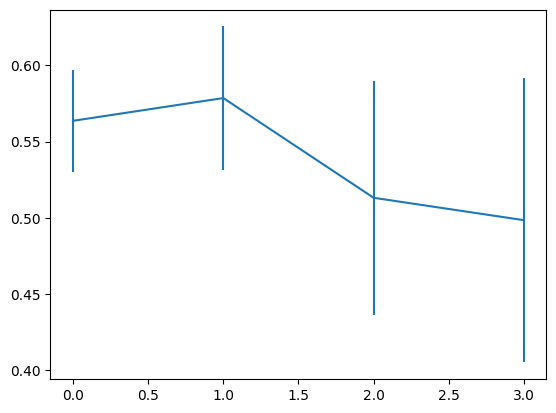

In [11]:
%matplotlib inline
plot_fitnesses(generations)

In [12]:
from pymol import cmd

ModuleNotFoundError: No module named 'pymol'

In [14]:
%pip install pymol-open-source

/home/ben/code/localcolabfold/colabfold-conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
ERROR: Could not find a version that satisfies the requirement pymol-open-source (from versions: none)
ERROR: No matching distribution found for pymol-open-source
Note: you may need to restart the kernel to use updated packages.
